# Porous media flow field estimation using a U-Net Architecture


### Resume

Over the last few years, the Computational Fluid Dynamics (CFD) community has benefited from the increasing development of Machine Learnin (ML), more specifically from advances from Deep Learning (DL) applications (Chen et al., 2019). As CFD provide detailed description of flow properties of interest by numerically solving a set of governing equations, major limitations regarding its high computational cost start to appear with the increase of complexity associated with the problem. Recent advances in DL have been successful on image-based problems such as generation, classification and denoising, followed by modern DL-CFD approaches are being used to address the increasing computational cost of complex CFD problems (King et al., 2018). In such applications, it is typical to use convolutional networks to provide pixel-wise classification, i.e. a class label is assigned to each pixel (Ronnenberger et al., 2015). In this project we address the numerical data from flow through an artificial porous medium microfluidic device in a pixel-wise classification manner by implementing a U-Net model, as recents studies showed that the model can be applied to find an efficient mapping between geometry and steady-state flow data (Ribeiro et al., 2020).  The U-Net architecture is trained with simulated porous media flow data to provide flow field estimations. The U-Net architecture was first introduced by Ronnenberger et al. (2015), and supplement a usual contracting network by successive convolution/max-pooling layers followed by an upscaling through deconvolution/concatenation/convolution layers several times (Chen et al., 2019). At last, we compare the computational cost of both CFD and DL approaches.

### References:
Chen, J., Viquerat, J., Hachem, E. (2019) U-net architectures for fast prediction in fluid
mechanics. 2019. ffhal-02401465f

King, R., Hennigh, O., Mohan, A., Chertkov, M. (2018). From Deep to Physics-Informed Learning of Turbulence: Diagnostics. Workshop on Modeling and Decision-Making in the Spatiotemporal Domain, 32nd Conference on Neural Information Processing Systems (NIPS 2018).

Ribeiro, M.D., Rehman, A., Ahmed, S., Dengel, A. (2020). DeepCFD: Efficient Steady-State Laminar Flow Approximation with Deep Convolutional Neural Networks. arXiv:2004.08826v2


Ronneberger O., Fischer P., Brox T. (2015) U-Net: Convolutional Networks for Biomedical Image Segmentation. In: Navab N., Hornegger J., Wells W., Frangi A. (eds) Medical Image Computing and Computer-Assisted Intervention – MICCAI 2015. MICCAI 2015. Lecture Notes in Computer Science, vol 9351. Springer, Cham. https://doi.org/10.1007/978-3-319-24574-4_28

### Import libraries

In [1]:
import os
import random
import numpy as np
import PIL
from PIL import Image
import glob
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn # All neural network modules, e.g. nn.Linear, nn.Conv2d, BatchNorm, Loss Functions
import torch.optim as optim # For all Optmization algorithms, SGD, Adam, etc
import torchvision.datasets as datasets # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader # Gives easier dataset management and creates mini batches
# from torch.utils.tensorboard import SummaryWriter # to print to tensorboard


print("PyTorch version: ", torch.__version__)

PyTorch version:  1.7.0+cu101


### Define data paths

In [2]:
# Get mesh and velocity data paths
mesh_paths = glob.glob('./mesh_data/*.tif')
vel_paths = glob.glob('./vel_data/*.tif')

total_samples = len(mesh_paths)
train_size = 0.85

# Separate training samples
train_mesh_paths = mesh_paths[:int(total_samples*train_size)]
train_vel_paths = vel_paths[:int(total_samples*train_size)]

# Separate test samples
test_mesh_paths = mesh_paths[int(total_samples*train_size):]
test_vel_paths = vel_paths[int(total_samples*train_size):]

print("Total samples:", total_samples)
print("Train samples", len(train_mesh_paths))
print("Test samples", len(test_mesh_paths))


Total samples: 200
Train samples 170
Test samples 30


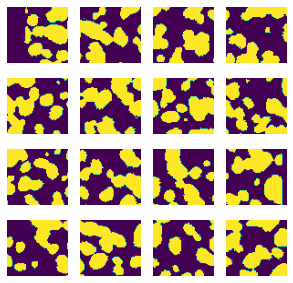

In [3]:
_, axes = plt.subplots(4, 4, figsize=(5, 5))
for ax, img_path in zip(axes.flatten(), train_mesh_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

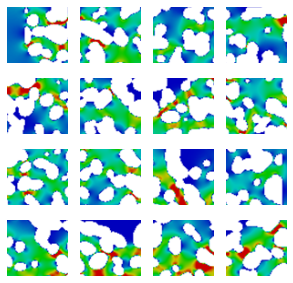

In [4]:
_, axes = plt.subplots(4, 4, figsize=(5, 5))
for ax, img_path in zip(axes.flatten(), train_vel_paths):
    ax.imshow(Image.open(img_path).convert('RGB'))
    ax.axis("off")

### Load the dataset

In [5]:
# Create a dataset class to consider an image pair 
SIZE = 64
class mesh_vel_dataset(Dataset):
    def __init__(self, mesh_dir, vel_dir, transform, train=True):
        self.mesh_dir = mesh_dir
        self.vel_dir = vel_dir
        self.transform = transform
    
    # def transform(self, mesh, vel):
        if train:
            self.mesh_transforms = self.transform.Compose([
                transforms.Resize(size = (SIZE,SIZE), interpolation = Image.NEAREST),
                # transforms.RandomHorizontalFlip(),
                ])
            self.vel_transforms = transform.Compose([
                transforms.Resize(size = (SIZE,SIZE), interpolation = Image.NEAREST),
                # transforms.RandomHorizontalFlip(),
                ])
        else:
            self.mesh_transforms = transform.Resize(size = (SIZE, SIZE), interpolation = Image.NEAREST)
            self.vel_transforms = transform.Resize(size = (SIZE, SIZE), interpolation = Image.NEAREST)
        # gray =  transforms.Grayscale(num_output_channels=1)
        
        # mesh = TF.to_tensor(resize_mesh(mesh))
        # vel = TF.to_tensor(resize_vel(vel))

        # vel = vel.__ge__(0.7).type(torch.FloatTensor)
        
        # return mesh, vel
    
    def __getitem__(self, idx): 
        '''
        This function actually loads the data
        '''
        mesh = Image.open(self.mesh_dir[idx])
        vel = Image.open(self.vel_dir[idx]).convert('RGB')

        # Transform image
        mesh = self.mesh_transforms(mesh)
        # mesh = np.array(mesh)
        # mesh = transforms.ToTensor()(mesh)
        mesh = TF.to_tensor(mesh)

        vel = self.vel_transforms(vel)
        # vel = np.array(vel)
        # vel = transforms.ToTensor()(vel)
        vel = TF.to_tensor(vel)

        # x, y = self.transform(mesh, vel) # mesh and velocity
        
        # return {'mesh': mesh, 'vel': vel}
        return mesh, vel
    
    def __len__(self):
        return len(self.mesh_dir)




In [6]:
def make_dataloaders(batch_size = 16, n_workers = 0, pin_memory=True, **kwargs):
    dataset = mesh_vel_dataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers, pin_memory=pin_memory)

    return dataloader

### Load the data

In [7]:
train_loader = make_dataloaders(mesh_dir=train_mesh_paths, vel_dir=train_vel_paths, transform = transforms, train=True)
test_loader = make_dataloaders(mesh_dir=test_mesh_paths, vel_dir=test_vel_paths, transform = transforms,train=False)

print('Number of training pairs (mesh + velocity): ', len(train_loader.dataset))
print('Number of testing pairs (mesh + velocity): ', len(test_loader.dataset))



Number of training pairs (mesh + velocity):  170
Number of testing pairs (mesh + velocity):  30


### Build the Network


In [8]:
def Conv_double(in_chans, out_chans):
    conv = nn.Sequential(
        nn.Conv2d(in_chans,out_chans, kernel_size =3,padding =1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_chans, out_chans, kernel_size =3,padding = 1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace=True)
    )
    return conv

def Crop_tensor(source, target):
    target_size = target.size()[2]
    source_size = source.size()[2]
    d = source_size - target_size
    if d>1:
        d = (int)(d // 2)
        return source[:,:,d:source_size-d, d:source_size-d]
    else:
        return source[:,:,d:source_size, d:source_size]

In [9]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size =2, stride =2)
        
        #convolutions
        self.down_conv1 = Conv_double(1,64)
        self.down_conv2 = Conv_double(64, 128)
        self.down_conv3 = Conv_double(128, 256)
        self.down_conv4 = Conv_double(256, 512)
        self.down_conv5 = Conv_double(512, 1024)
        
        #up-convolutions
        self.conv_trans1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size=2, stride=2)
        self.up_conv1 = Conv_double(1024, 512)
        
        self.conv_trans2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size=2, stride=2)
        self.up_conv2 = Conv_double(512, 256)
        
        self.conv_trans3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=2, stride=2)
        self.up_conv3 = Conv_double(256, 128)
        
        self.conv_trans4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size=2, stride=2)
        self.up_conv4 = Conv_double(128, 64)
    
        #output
        self.out = nn.Conv2d(in_channels = 64, out_channels = 3,kernel_size=1)
        
    def forward(self, img):
        #bs,c,h,w
        #encoder
        x1 = self.down_conv1(img) # 
        x2 = self.maxpool(x1)
        x3 = self.down_conv2(x2)   #
        x4 = self.maxpool(x3)
        x5 = self.down_conv3(x4)   #
        x6 = self.maxpool(x5)
        x7 = self.down_conv4(x6)   #
        x8 = self.maxpool(x7)
        x9 = self.down_conv5(x8) 
        
        #decoder
        x = self.conv_trans1(x9)  
        #crop tensor
        y = Crop_tensor(x7, x)        
        #conacatenate
        x = self.up_conv1(torch.cat([x,y],1))
        
        x = self.conv_trans2(x)        
        y = Crop_tensor(x5, x)        
        x = self.up_conv2(torch.cat([x,y],1))
        
        x = self.conv_trans3(x)        
        y = Crop_tensor(x3, x)
        x = self.up_conv3(torch.cat([x,y],1))
        
        x = self.conv_trans4(x)        
        y = Crop_tensor(x1, x)
        x = self.up_conv4(torch.cat([x,y],1))
        
        x = self.out(x)
        
        return x

### Build the Model

In [10]:
num_epochs=60
samples=3
batch=5
betas=(0.5,0.5)
lr = 0.001
size = 64
data_path = './models'
# dataloader = train_loader
# transforms = None

In [11]:
if torch.cuda.is_available():
    device = 'cuda'

In [12]:
Net =  UNet()
Net.cuda() # Move model into cuda GPU
from torchsummary import summary
summary(Net, (1, 64, 64)) # Print model summary 
Opt = optim.Adam(Net.parameters(), lr = lr, betas=(0.9, 0.999))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]             640
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,928
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
         MaxPool2d-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          73,856
       BatchNorm2d-9          [-1, 128, 32, 32]             256
             ReLU-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]         147,584
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 128,

In [13]:
decay_factor = 0.5 
L1_loss = nn.L1Loss()

losses = []

### Predicted values before training

In [14]:
data = iter(train_loader)
malha, velo = data.next()
print(malha.shape)
print('Test Velocity shape: ', velo.shape)
malha = malha.cuda()
fakevelo = Net(malha)
print('Predicted Velocity shape: ', fakevelo.shape)

torch.Size([16, 1, 64, 64])
Test Velocity shape:  torch.Size([16, 3, 64, 64])
Predicted Velocity shape:  torch.Size([16, 3, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'Predicted velocity field (not trained)')

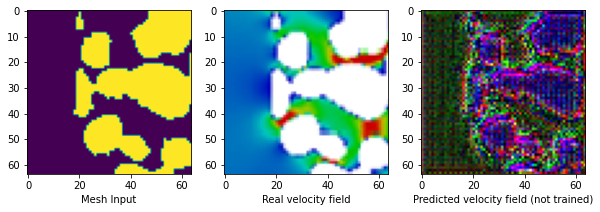

In [15]:
fig = plt.figure(figsize = (10,8))

plt.subplot(1, 3, 1)
plt.imshow(malha[0].detach().cpu().permute(1,2,0))
plt.xlabel('Mesh Input')

plt.subplot(1, 3, 2)
plt.imshow(velo[0].detach().cpu().permute(1,2,0))
plt.xlabel('Real velocity field')

plt.subplot(1, 3, 3)
plt.imshow(fakevelo[0].detach().cpu().permute(1,2,0))
plt.xlabel('Predicted velocity field (not trained)')

### Training the model

In [16]:
print("Start training...")
for epoch in range(num_epochs):
    for batch_idx, (meshes, vels) in enumerate(train_loader):
        
        # Send data to device
        meshes = meshes.to(device)
        vels = vels.to(device)
        Opt.zero_grad()

        # Generate fake velocity image
        fake_vels = Net(meshes)

        # Calculate loss
        loss = L1_loss(fake_vels, vels)
        # print("Current loss: ", loss)
        losses.append(loss)
        loss.backward()
        Opt.step()

        if(epoch%10 == 0  and batch_idx==0):
            print('Epoch : ', epoch)
            print("Loss: ",loss)

print("Training finished.")

Start training...
Epoch :  0
Loss:  tensor(0.5535, device='cuda:0', grad_fn=<L1LossBackward>)
Epoch :  10
Loss:  tensor(0.0982, device='cuda:0', grad_fn=<L1LossBackward>)
Epoch :  20
Loss:  tensor(0.0771, device='cuda:0', grad_fn=<L1LossBackward>)
Epoch :  30
Loss:  tensor(0.0655, device='cuda:0', grad_fn=<L1LossBackward>)
Epoch :  40
Loss:  tensor(0.0646, device='cuda:0', grad_fn=<L1LossBackward>)
Epoch :  50
Loss:  tensor(0.0666, device='cuda:0', grad_fn=<L1LossBackward>)
raining finished.


### Plot model loss

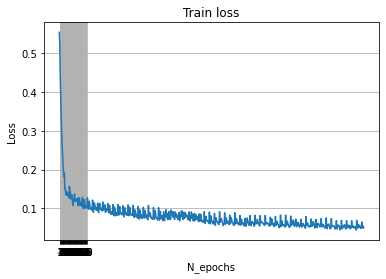

In [25]:
plt.plot(losses, label="UNet")
plt.xticks(np.arange(1, num_epochs, 1))
plt.grid()
plt.title("Train loss")
plt.xlabel("N_epochs")
plt.ylabel("Loss")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'Absolute error ')

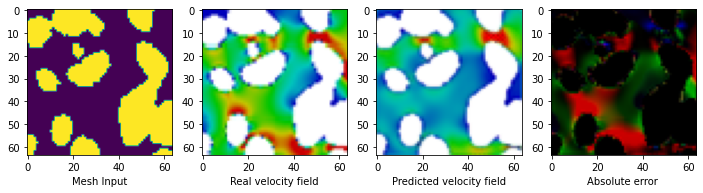

In [53]:
data = iter(test_loader)
malha, velo = data.next()
malha = malha.cuda()
fakevelo = Net(malha)

fig = plt.figure(figsize = (12,10))

plt.subplot(1, 4, 1)
plt.imshow(malha[0].detach().cpu().permute(1,2,0))
plt.xlabel('Mesh Input')

plt.subplot(1, 4, 2)
plt.imshow(velo[0].detach().cpu().permute(1,2,0))
plt.xlabel('Real velocity field')

plt.subplot(1, 4, 3)
plt.imshow(fakevelo[0].detach().cpu().permute(1,2,0))
plt.xlabel('Predicted velocity field')

tvel = velo[0].detach().cpu().permute(1,2,0)
tfakevel = fakevelo[0].detach().cpu().permute(1,2,0)
error = (tvel - tfakevel)
plt.subplot(1, 4, 4)
plt.imshow(error)
plt.xlabel('Absolute error ')